## Construir e Treinar um Modelo de Linguagem Simples com uma Rede Neural


Este projeto serve como introdução ao campo de modelagem de linguagem, com foco na criação de um gerador de texto voltado para compor músicas de rap dos anos 90. É utilizado modelos de N-grama baseados em histogramas, implementados através da Natural Language Toolkit (NLTK). Essa abordagem permite construir histogramas reveladores, que elucidam cadências sutis nas frequências e distribuições de palavras.


### Objetivos
- Utilizar modelos de N-grama baseados em histogramas, implementados através da Natural Language Toolkit (NLTK), para analisar e entender frequências e distribuições de palavras.
- Implementar uma rede neural feedforward usando a estrutura PyTorch, incluindo camadas de embedding, para tarefas de modelagem de linguagem.
- Ajustar a camada de saída da rede neural para obter desempenho ideal na geração de texto.
- Aplicar diversas estratégias de treinamento e técnicas fundamentais de Processamento de Linguagem Natural (NLP), como tokenização e análise de sequência, para aprimorar a geração de texto.

### Preparar setup - instalar bibliotecas


In [1]:
def warn(*args, **kwargs):
    pass
    
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import importlib.util
import subprocess
import sys

def check_and_install(package, pip_name=None):
    if pip_name is None:
        pip_name = package
    spec = importlib.util.find_spec(package)
    if spec is None:
        print(f"{package} não está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    else:
        print(f"{package} já está instalado.")

In [2]:
check_and_install('nltk')
check_and_install('torchtext')

nltk já está instalado.
torchtext já está instalado.


### Importar bibliotecas

In [83]:
import time
from tqdm import tqdm
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\murilo.silvestrini\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package punkt is already up-to-date!


### Definir funções auxiliares

In [4]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

### Modelagem de Linguagem
A modelagem de linguagem é um conceito fundamental no campo de processamento de linguagem natural (NLP) e inteligência artificial. Ela envolve a previsão da probabilidade de uma sequência de palavras em uma determinada língua. Esse método é de natureza estatística e busca capturar os padrões, estruturas e relações existentes entre palavras em um corpus de texto.

Em essência, um modelo de linguagem se esforça para entender as probabilidades associadas a sequências de palavras. Esse entendimento pode ser aplicado a uma variedade de tarefas de NLP, incluindo, mas não se limitando a, geração de texto, tradução automática, reconhecimento de fala, análise de sentimentos e muito mais.

Vamos considerar as letras de uma música a seguir para determinar se você consegue gerar uma saída semelhante usando uma palavra específica.

In [5]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

### Natural Language Toolkit (NLTK)
O NLTK é uma biblioteca de código aberto amplamente utilizada em Python, projetada especificamente para diversas tarefas de processamento de linguagem natural (NLP). Ela oferece um conjunto abrangente de ferramentas, recursos e algoritmos que auxiliam na análise e manipulação de dados de linguagem humana.



### Tokenização
A tokenização, um conceito fundamental no processamento de linguagem natural (NLP), envolve o processo de dividir um corpo de texto em unidades discretas conhecidas como tokens. Esses tokens podem ser palavras, frases, sentenças ou até caracteres individuais, adaptando-se com base no nível de granularidade desejado para análise. 

- Tokenização de Palavras: técnica que trata cada palavra no texto como uma entidade independente. Palavras, geralmente separadas por espaços ou marcas de pontuação, servem como tokens nessa abordagem. É importante notar que a Tokenização de Palavras exibe características versáteis, como distinção entre maiúsculas e minúsculas, símbolos e pontuação.

Será utilizado a função word_tokenize. Durante esse processo, você removerá pontuação, símbolos e letras maiúsculas.

In [6]:
from nltk.tokenize import word_tokenize

In [7]:
def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w) for w in tokens]
    return [w.lower() for w in tokens if len(w) != 0 or not (w in string.punctuation)]

In [8]:
tokens = preprocess(song)

In [9]:
tokens[0:10]

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

A distribuição de frequência de palavras em uma sentença representa a frequência com que cada palavra aparece nessa sentença específica. Ela fornece uma contagem das ocorrências de palavras individuais, permitindo entender quais palavras são mais comuns ou frequentes na sentença dada. Vamos trabalhar com o seguinte exemplo simples:

Texto: "I like dogs and I kinda like cats"

Tokens: ["I", "like", "dogs", "and", "I", "kinda", "like", "cats"]

A função Count irá contar as ocorrências de palavras no texto de entrada.

$Count("I")=2$

$Count("like")= 2$

$Count("dogs")=1$

$Count("and")=1$

$Count("kinda")=1$

$Count("cats")=1$

$\text{Total words} =8$


Utilize o ```NLTK's FreqDist``` para transformar uma distribuição de frequência de palavras. O resultado é um dicionário Python onde as chaves correspondem a palavras, e os valores indicam a frequência de aparição de cada palavra.

In [10]:
# Create a frequency distribution of words
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

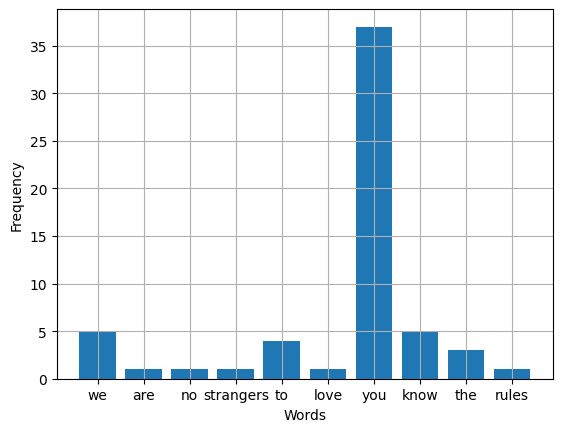

In [11]:
plt.bar(list(fdist.keys())[0:10], list(fdist.values())[0:10])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.grid()
plt.show()

### Modelo Unigram
Um modelo unigram é um tipo simples de modelo de linguagem que considera cada palavra em uma sequência independentemente, sem levar em conta as palavras anteriores. Em outras palavras, ele modela a probabilidade de cada palavra ocorrer no texto, independentemente do que veio antes dela. Os modelos unigram podem ser vistos como um caso especial de modelos n-gram, onde n é 1.

Você pode pensar que o texto segue padrões, e as probabilidades são usadas para medir a probabilidade de uma sequência de palavras. Em um modelo unigram, cada palavra é considerada independente e não depende das outras. Vamos calcular a probabilidade de **'I like tiramisu but I love cheesecake more'**.

$  P(\text{"I"}) = \frac{\text{Count}(\text{"I"})}{\text{Total words}}=\frac{2}{8} = 0.250  $

$  P(\text{"like"}) = \frac{\text{Count}(\text{"like"})}{\text{Total words}}=\frac{1}{8} = 0.125  $

$  P(\text{"tiramisu"}) = \frac{\text{Count}(\text{"tiramisu"})}{\text{Total words}}=\frac{1}{8} = 0.125  $

$  P(\text{"but"}) = \frac{\text{Count}(\text{"but"})}{\text{Total words}}=\frac{1}{8} = 0.125  $

$  P(\text{"I"}) = \frac{\text{Count}(\text{"I"})}{\text{Total words}}=\frac{2}{8} = 0.250  $

$  P(\text{"love"}) = \frac{\text{Count}(\text{"love"})}{\text{Total words}}=\frac{1}{8} = 0.125  $

$  P(\text{"cheesecake"}) = \frac{\text{Count}(\text{"cheesecake"})}{\text{Total words}}=\frac{1}{8} = 0.125  $

$  P(\text{"more"}) = \frac{\text{Count}(\text{"more"})}{\text{Total words}}=\frac{1}{8} = 0.125  $

$P(\text{"I"}, \text{"like"}, \text{"tiramisu"}, \text{"but"}, \text{"I"}, \text{"love"}, \text{"cheesecake"}, \text{"more"}) = P(\text{"I"}) \cdot P(\text{"like"}) \cdot P(\text{"tiramisu"}) \cdot P(\text{"but"}) \cdot P(\text{"I"}) \cdot P(\text{"love"}) \cdot P(\text{"cheesecake"}) \cdot P(\text{"more"}) = 0.250 \times 0.125 \times 0.125 \times 0.125 \times 0.250 \times 0.125 \times 0.125 \times 0.125$

Em geral, os modelos de linguagem se resumem à previsão de uma sequência de comprimento $t$: $P(W_t, W_{t-1}, ..., W_0)$. Nesta sequência de oito palavras, você tem:

$P(W_7=\text{"more"}, W_6=\text{"cheesecake"}, W_5=\text{"love"}, W_4=\text{"I"}, W_3=\text{"but"}, W_2=\text{"tiramisu"}, W_1=\text{"like"}, W_0=\text{"I"})$

O subscrito serve como um indicador posicional na sequência e não impacta a natureza de $P(\bullet)$. Ao expressar formalmente a sequência, a última palavra é posicionada no lado mais à esquerda, descendo gradualmente conforme você avança pela sequência.

Usando NLTK, podemos normalizar os valores de frequência dividindo-os pela contagem total de cada palavra para obter uma função de probabilidade. Calcular a probabilidade de cada palavra.

In [12]:
# Total count of each word
C = sum(fdist.values())
C

385

In [13]:
fdist['strangers']/C

0.0025974025974025974

In [14]:
vocabulary=set(tokens)

### Como o modelo unigram prevê a próxima palavra provável
Vamos considerar um cenário do exemplo acima, "I like tiramisu but I love cheesecake more", onde o modelo unigram é solicitado a prever a próxima palavra após a sequência "I like".

Se a maior probabilidade entre todas as palavras for "I" com uma probabilidade de 0,25, então, de acordo com o modelo, a próxima palavra mais provável após "I like" seria "I". No entanto, essa previsão não faz sentido algum. Isso destaca uma limitação significativa do modelo unigram — ele não possui contexto, e suas previsões são totalmente dependentes da palavra com a maior probabilidade, "I" neste caso.

Mesmo que várias palavras tenham as mesmas maiores probabilidades, ele escolherá aleatoriamente uma das opções.

### Modelo Bigram
Os bigramas representam pares de palavras consecutivas na frase dada, ou seja, $(w_{t-1},w_t)$

Considere as seguintes palavras do seu exemplo: "I like dogs and I kinda like cats."

A sequência correta de bigramas é:

$(I, like)$

$(like, dogs)$

$(dogs, and)$

$(and, I)$

$(I, kinda)$

$(kinda, like)$

$(like, cats)$

**Modelos de 2 gramas**: Os modelos bigrama usam probabilidade condicional. A probabilidade de uma palavra depende apenas da palavra anterior, ou seja, a probabilidade condicional $(W_{t}, W_{t-1})$ é usada para prever a probabilidade da palavra $(W_t)$ seguir a palavra $W_{t-1}$ em uma sequência. Podemos calcular a probabilidade condicional para um modelo bigrama usando as seguintes etapas.

Execute a contagem de palavras do bigrama para cada bigrama: $Count(W_{t-1}, W_{t})$
$Count(\text{I, like}) = 1$

$Count(\text{like, dogs}) = 1$

$Count(\text{dogs, and}) = 1$

$Count(\text{and, I}) = 1$

$Count(\text{I, kinda}) = 1$

$Count(\text{kinda, like}) = 1$

$Count(\text{like, cats}) = 1$

Calcular a probabilidade condicional para cada bigrama na forma de $P(w_{t} | w_{t-1})$, onde $w_{t-1}$ é o **contexto** e o tamanho do contexto é um.
$P(\text{"like"} | \text{"I"}) = \frac{\text{Count}(\text{"I, like"})}{\text{Total count of "I"}} = \frac{1}{2} = 0.5$

$P(\text{"dogs"} | \text{"like"}) = \frac{\text{Count}(\text{"like, dogs"})}{\text{Total count of "like"}} = \frac{1}{2} = 0.5$

$:$

$P(\text{"like"} | \text{"kinda"}) = \frac{\text{Count}(\text{"kinda, like"})}{\text{Total count of "kinda"}} = \frac{1}{1} = 1$

$P(\text{"cats"} | \text{"like"}) = \frac{\text{Count}(\text{"like, cats"})}{\text{Total count of "like"}} = \frac{1}{2} = 0.5$

Essas probabilidades representam a probabilidade de encontrar a segunda palavra em um bigrama, dada a presença da primeira palavra.

Essa abordagem é, na verdade, uma aproximação usada para determinar a palavra mais provável $W_t$, dadas as palavras $W_{t-1}, W_{t-2}, \ldots, W_1$ na sequência.
$P(W_t | W_{t-1}, W_{t-2}, \ldots, W_1) \approx P(W_t | W_{t-1})$

A probabilidade condicional $P(W_t | W_{t-1})$ significa a probabilidade de encontrar a palavra $W_t$, com base no contexto fornecido pela palavra precedente $W_{t-1}$. Ao empregar essa aproximação, simplifique o processo de modelagem assumindo que a ocorrência da palavra atual é influenciada principalmente pela palavra mais recente na sequência. Em geral, você tem a capacidade de identificar a palavra mais provável.

$\hat{W_t} = \arg\max_{W_t} \left( P(W_t | W_{t-1}) \right)$


```bigrams``` é uma função fornecida pela biblioteca Natural Language Toolkit (NLTK) em Python. Esta função recebe uma sequência de tokens como entrada e retorna um iterador sobre pares consecutivos de tokens, formando bigramas.

In [15]:
bigrams = nltk.bigrams(tokens)
bigrams

<generator object bigrams at 0x000001FA958351C0>

Converta um gerador em uma lista, onde cada elemento da lista é um bigrama.

In [16]:
my_bigrams = list(nltk.bigrams(tokens))

In [17]:
my_bigrams[0:10]

[('we', 'are'),
 ('are', 'no'),
 ('no', 'strangers'),
 ('strangers', 'to'),
 ('to', 'love'),
 ('love', 'you'),
 ('you', 'know'),
 ('know', 'the'),
 ('the', 'rules'),
 ('rules', 'and')]

Calcular a distribuição de frequência do bigrama $C(w_{t},w_{t-1})$ usando a função NLTK ```bigrams```.

In [18]:
freq_bigrams = nltk.FreqDist(nltk.bigrams(tokens))
freq_bigrams

FreqDist({('gon', 'na'): 38, ('never', 'gon'): 36, ('you', 'never'): 9, ('na', 'tell'): 8, ('make', 'you'): 8, ('na', 'give'): 6, ('give', 'you'): 6, ('you', 'up'): 6, ('up', 'never'): 6, ('na', 'let'): 6, ...})

In [19]:
freq_bigrams[('we', 'are')]

1

In [20]:
# first 10 values of the frequency distribution.
for my_bigram in my_bigrams[0:10]:
    print(my_bigram)
    print(freq_bigrams[my_bigram])

('we', 'are')
1
('are', 'no')
1
('no', 'strangers')
1
('strangers', 'to')
1
('to', 'love')
1
('love', 'you')
1
('you', 'know')
1
('know', 'the')
3
('the', 'rules')
1
('rules', 'and')
1


Gerar a distribuição condicional normalizando a distribuição de frequência de unigramas. Neste caso, vamos fazer para a palavra 'strangers' e então classificando os resultados:

In [21]:
word="strangers"
vocab_probabilities={}
for next_word in vocabulary:
    vocab_probabilities[next_word]=freq_bigrams[(word,next_word)]/fdist[word]

vocab_probabilities=sorted(vocab_probabilities.items(), 
                           key=lambda x:x[1],reverse=True)

In [22]:
vocab_probabilities[0:4]

[('to', 1.0), ('guy', 0.0), ('whats', 0.0), ('were', 0.0)]

Criar uma função para calcular a probabilidade condicional de $W_t$ dado $W_{t-1}$, classifique os resultados e gere-os como uma lista.

In [23]:
def make_predictions(my_words, freq_grams, normlize=1, vocabulary=vocabulary):
    """
    Generate predictions for the conditional probability of 
    the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, 
        sorted in descending order.
    """
    # Initialize a dictionary to store predicted word probabilities
    vocab_probabilities = {}  

    # Determine the context size from n-grams keys
    context_size = len(list(freq_grams.keys())[0])
    
    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate probabilities for each word in the vocabulary given the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequency information
        if normlize!=0:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] 
    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)

    # Return the sorted list of predicted words and their probabilities
    return vocab_probabilities  

Definir $W_{t-1}$ como 'i' e então calcular todos os valores de $P(W_t | W_{t-1}=i)$.

In [24]:
my_words="are"

vocab_probabilities=make_predictions(my_words,freq_bigrams,normlize=fdist['i'])

In [25]:
vocab_probabilities[0:10]

[('no', 0.3333333333333333),
 ('guy', 0.0),
 ('whats', 0.0),
 ('were', 0.0),
 ('say', 0.0),
 ('shy', 0.0),
 ('rules', 0.0),
 ('im', 0.0),
 ('your', 0.0),
 ('both', 0.0)]

A palavra com maior probabilidade, denotada como $\hat{W}_t$, é dada pelo primeiro elemento da lista, o que pode ser usado como um preenchimento automático simples:

In [26]:
vocab_probabilities[0][0]

'no'

Gerar uma sequência usando o modelo bigram aproveitando a palavra anterior (t-1) para prever e gerar a palavra subsequente na sequência.

In [27]:
my_song=""
for w in tokens[0:100]:
  my_word=make_predictions(w,freq_bigrams)[0][0]
  my_song+=" "+my_word

In [28]:
my_song

' both no strangers to say you never the game and hurt long i just lie commitments what im feeling of you never get this from any other for i just wan na tell a never im feeling got ta make you never never gon na tell you never never gon na tell you never never gon na tell around and hurt you never gon na tell you never never gon na tell goodbye never gon na tell a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say goodbye'

Criar uma sequência usando o modelo n-gram iniciando o processo com a primeira palavra na sequência e produzindo uma saída inicial. Posteriormente, utilizar essa saída como base para gerar a próxima palavra na sequência, ou seja, dar ao modelo uma palavra, então usará a saída para prever a próxima palavra e repetir.

In [29]:
my_song="i"

for i in range(100):
    my_word=make_predictions(my_word,freq_bigrams)[0][0]
    my_song+=" "+my_word

In [30]:
my_song

'i never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never'

Existem vários desafios associados aos métodos baseados em histogramas, alguns dos quais são bastante diretos. Por exemplo, ao considerar o caso de ter N palavras em seu vocabulário, um modelo Unigram exigiria $N$ bins, enquanto um modelo Bigram resultaria em $N^2$ bins e assim por diante.

Os modelos N-gram também enfrentam limitações em termos de compreensão contextual e de sua capacidade de capturar relações complexas entre palavras. Por exemplo, vamos considerar as frases "I hate dogs", "I don’t like dogs" e "don’t like means dislike". Nesse contexto, uma abordagem baseada em histogramas falharia em captar o significado da frase "don’t like means dislike", perdendo, assim, a relação semântica essencial que ela representa.


### Redes Neurais Feedforward (FNNs) para modelos de linguagem

FNNs, ou Perceptrons Multicamadas, servem como componentes fundamentais para a compreensão de redes neurais no processamento de linguagem natural (NLP). Em tarefas de NLP, os FNNs processam dados textuais transformando-os em vetores numéricos conhecidos como embeddings. Esses embeddings são então inseridos na rede para prever aspectos da linguagem, como a próxima palavra em uma frase ou o sentimento de um texto.

In [31]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

### Tokenization for FNN

Função do PyTorch usada para obter um tokenizador para o texto

In [32]:
tokenizer = get_tokenizer('basic_english')
tokens = tokenizer(song)

### Indexing
O TorchText fornece ferramentas para tokenizar texto em palavras individuais (tokens) e construir um vocabulário, que mapeia tokens para índices inteiros exclusivos. Esta é uma etapa crucial na preparação de dados de texto para modelos de aprendizado de máquina que exigem entrada numérica.

In [34]:
# Create a vocabulary from text tokens

# tokenize the 'song' text using the provided tokenizer.
# The map function applies the tokenizer to each word in the 'song' after splitting it.
# The result is a list of tokens representing the words in the 'song'.
tokenized_song = map(tokenizer, song.split())

In [37]:
# Step 2: Vocabulary Building
# The build_vocab_from_iterator function constructs a vocabulary from the tokenized text.
# In this case, add a special token "<unk>" (unknown token) to handle out-of-vocabulary words.
vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])

In [39]:
# Step 3: Set Default Index
# Set the default index for the vocabulary to the index corresponding to the "<unk>" token.
# This ensures that any unknown tokens in the future will be mapped to this index.
vocab.set_default_index(vocab["<unk>"])

In [40]:
# Convert the tokens to indices by applying the function as shown 
vocab(tokens[0:10])

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [44]:
# Write a text function that converts raw text into indexes.
text_pipeline = lambda x: vocab(tokenizer(x))

In [45]:
text_pipeline(song)[0:10]

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [46]:
# Find the word corresponding to an index using theget_itos()method. 
# The result is a list where the index of the list corresponds to a word.
index_to_token = vocab.get_itos()
index_to_token[0]

'<unk>'

### Camadas de Embedding
Uma camada de embedding é um elemento crucial em processamento de linguagem natural (NLP) e em redes neurais projetadas para dados sequenciais. Ela serve para converter variáveis categóricas, como palavras ou índices discretos representando tokens, em vetores contínuos. Essa transformação facilita o treinamento e permite que a rede aprenda relações significativas entre palavras.

Vamos considerar um exemplo simples com um vocabulário de palavras:

- Vocabulário: {apple, banana, orange, pear}

Cada palavra no seu vocabulário tem um índice exclusivo atribuído a ela:
- Índices: {0, 1, 2, 3}

Ao usar uma camada de embedding, você inicializará vetores contínuos aleatórios para cada índice. Por exemplo, os vetores de embedding podem ser algo como:

- Vector for index 0 (apple): [0.2, 0.8]
- Vector for index 1 (banana): [0.6, -0.5]
- Vector for index 2 (orange): [-0.3, 0.7]
- Vector for index 3 (pear): [0.1, 0.4]ão.

In [47]:
embedding_dim = 0
vocab_size = len(vocab)
embeddings = nn.Embedding(vocab_size, embedding_dim)

In [48]:
embeddings

Embedding(79, 0)

**Embeddings:** Obtenha o embedding para a primeira palavra com índice 0 ou 1. Não se esqueça de que você tem que converter a entrada em um tensor. Os embeddings são inicialmente inicializados aleatoriamente, mas conforme o modelo passa pelo treinamento, palavras com significados semelhantes gradualmente se agrupam mais próximas

In [49]:
for n in range(2):
    embedding = embeddings(torch.tensor(n))
    print('word', index_to_token[n])
    print('index', n)
    print('embedding', embedding)
    print('embedding shape', embedding.shape)

word <unk>
index 0
embedding tensor([], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([0])
word gonna
index 1
embedding tensor([], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([0])


Esses vetores servirão como entradas para a próxima camada.

### Gerando pares contexto-alvo (n-gramas)
Organize palavras dentro de um contexto de tamanho variável usando a seguinte abordagem: Cada palavra é denotada por 'i'. Para estabelecer o contexto, simplesmente subtraia 'j'. O tamanho do contexto é determinado pelo valor de CONTEXT_SIZE.

In [50]:
CONTEXT_SIZE = 2

ngrams = [
    (
        [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],
        tokens[i]
    )
    for i in range(CONTEXT_SIZE, len(tokens))
]

Produza o primeiro elemento, que resulta em uma tupla. O elemento inicial representa o contexto, e o índice indica a palavra seguinte.

In [51]:
context, target = ngrams[0]
print('context', context, 'target', target)
print('context index', vocab(context), 'target index', vocab([target]))

context ['are', 'we'] target no
context index [58, 21] target index [70]


Neste contexto, há várias palavras. Agregue os embeddings de cada uma dessas palavras e então ajuste o tamanho de entrada da camada subsequente de acordo. Então, crie a próxima camada.

In [52]:
linear = nn.Linear(embedding_dim * CONTEXT_SIZE, 128)

In [57]:
my_embeddings = embeddings(torch.tensor(vocab(context)))

In [59]:
#  two embeddings
my_embeddings.shape

torch.Size([2, 0])

In [60]:
# Reshape the embeddings
my_embeddings = my_embeddings.reshape(1, -1)
my_embeddings.shape

torch.Size([1, 0])

In [61]:
#  Used as inputs in the next layer
linear(my_embeddings)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddmmBackward0>)

### Função Batch
Criar uma função Batch para interagir com o carregador de dados. Vários ajustes são necessários para lidar com palavras que são parte de um contexto em um lote e uma palavra prevista no lote seguinte.

In [62]:
from torch.utils.data import DataLoader

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [64]:
CONTEXT_SIZE=3
BATCH_SIZE=10
EMBEDDING_DIM = 10

In [66]:
def collate_batch(batch):
    batch_size=len(batch)
    context, target=[],[]
    for i in range(CONTEXT_SIZE,batch_size):
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))

    return torch.tensor(context).to(device),  torch.tensor(target).to(device).reshape(-1)

Da mesma forma, é importante destacar que o tamanho do último batch pode diferir dos batches anteriores. Para lidar com isso, a abordagem envolve ajustar o batch final para se conformar ao tamanho especificado, garantindo que ele seja um múltiplo do tamanho predeterminado. Quando necessário, você usará técnicas de preenchimento (padding) para alcançar essa harmonização. Uma das abordagens que você usará é adicionar o início da música ao final do batch.

In [67]:
Padding = BATCH_SIZE-len(tokens) % BATCH_SIZE
tokens_pad = tokens+tokens[0:Padding]

In [68]:
# Create the DataLoader.
dataloader = DataLoader(
    tokens_pad,
    batch_size=BATCH_SIZE,
    shuffle = False,
    collate_fn=collate_batch
)

### Rede Neural Multiclasse
Foi desenvolvida uma classe no PyTorch para uma rede neural multiclasse. A saída da rede é a probabilidade da próxima palavra dentro de um determinado contexto. Assim, o número de classes corresponde à quantidade de palavras distintas. A camada inicial consiste em embeddings, e, além da camada final, uma camada oculta adicional é incorporada.

In [69]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.context_size=context_size
        self.embedding_dim=embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds=torch.reshape( embeds, (-1,self.context_size * self.embedding_dim))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)

        return out

In [70]:
# Create a model
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

In [72]:
# Retrieve samples from the data loader object and input them into the neural network.
context, target = next(iter(dataloader))
out = model(context)

Enquanto o modelo permanece sem treinamento, analisar a saída pode nos fornecer um entendimento mais claro. Na saída, a primeira dimensão corresponde ao tamanho do lote, enquanto a segunda dimensão representa a probabilidade associada a cada classe.

In [73]:
out.shape

torch.Size([7, 79])

In [74]:
# Find the index with the highest probability
predicted_index = torch.argmax(out,1)
predicted_index

tensor([21, 49, 71, 47, 14, 40,  5])

In [75]:
# Find the corresponding token
[index_to_token[i.item()] for i in  predicted_index]

['we', 'play', 'of', 'me', 'goodbye', 'going', 'tell']

In [76]:
# Create a function that accomplishes the same task for the tokens
def write_song(model,number_of_words=100):
    my_song=""
    for i in range(number_of_words):
        with torch.no_grad():
            context=torch.tensor(vocab([tokens[i-j-1] for j in range(CONTEXT_SIZE)])).to(device)
            word_inx=torch.argmax(model(context))
            my_song+=" "+index_to_token[word_inx.detach().item()]

    return my_song

In [77]:
write_song(model)

' goodbye too whats we play of me goodbye going tell goodbye wouldnt <unk> goodbye goodbye lie around say goodbye tell shy love goodbye of goodbye we say wanna of never say run goodbye of this goodbye tell a wanna lie love to around goodbye on goodbye lie goodbye lie wouldnt goodbye rules how goodbye if goodbye on love get goodbye lie been goodbye of lie goodbye lie gotta say goodbye to on any love this goodbye goodbye this lie we goodbye run goodbye too lie run goodbye lie rules love of how full around of play lie rules lie goodbye'

### Treinamento
Treinar um modelo de linguagem envolve um processo em várias etapas que utiliza dados de treinamento e teste para otimizar o desempenho do modelo. No campo do Processamento de Linguagem Natural (NLP), esse processo costuma empregar várias métricas para avaliar a precisão do modelo, como perplexidade ou acurácia em dados não vistos. No entanto, no contexto da exploração atual, vamos seguir um caminho diferente. Em vez de depender exclusivamente de métricas convencionais de NLP, o foco se volta para a inspeção manual dos resultados.


In [78]:
# cross entropy loss between input logits and target
criterion = torch.nn.CrossEntropyLoss()

Criar uma função dedicada a treinar o modelo usando o carregador de dados fornecido. Além de treinar o modelo, a saída da função inclui previsões para cada época, abrangendo o contexto para as próximas 100 palavras.

In [79]:
def train(dataloader, model, number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            my_song += write_song(model)  # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [80]:
# The following list will be used to store the loss for each model
my_loss_list=[]

Este segmento de código inicializa um modelo de linguagem n-gram com um tamanho de contexto de 2. O modelo `model_2`, é configurado com base no tamanho do vocabulário fornecido, dimensão de incorporação e tamanho do contexto. O otimizador Stochastic Gradient Descent (SGD) é empregado com uma taxa de aprendizado de 0.01 para gerenciar atualizações de parâmetros do modelo. Um agendador de taxa de aprendizado, usando uma abordagem passo a passo com um fator de redução de 0.1 por época, é configurado para adaptar a taxa de aprendizado durante o processo de treinamento. Essas configurações estabelecem coletivamente a estrutura para treinar o modelo de linguagem n-gram com otimização personalizada e ajuste de taxa de aprendizado.

In [81]:
# Define the context size for the n-gram model
CONTEXT_SIZE = 2

# Create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the optimizer for training the model, using stochastic gradient descent (SGD)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up a learning rate scheduler using StepLR to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

In [84]:
# Train the model
my_loss=train(dataloader,model_2)

 10%|████████                                                                         | 10/100 [00:00<00:01, 45.99it/s]

Generated Song:


 and gonna never me <unk> im it and it it blind gonna if it guy no and it the it me guy and from gonna never this gonna <unk> for the never weve guy so gonna full gonna the me so never gonna from around and gonna and from get gonna never gonna from <unk> gonna gonna it no gonna from gonna so gonna and from guy never from from the ask <unk> gonna and and never guy and so so hearts thinking me get the it guy it and gonna me the this gonna gonna and it it gonna
Generated Song:


 never never you gonna you never you gonna never never never you you you never never and you never gonna you you you never gonna you never tell never never never never gonna you never never you you you you never never gonna tell you you never gonna tell you you never gonna tell you you you you never gonna tell you never never gonna tell you never gonna tell you never and you you never never you you never never you you never you you you you you gonna never you you never you you you you never you


 25%|████████████████████▎                                                            | 25/100 [00:00<00:01, 40.81it/s]

Generated Song:


 never never you you you never you and never never tell you you you never never and you never around tell you and never gonna you never tell around and never never tell you never never you you you you never never gonna tell you up never gonna tell you down never gonna tell around and you you never gonna tell you never never gonna tell you never gonna tell you never and hurt you never never each you never and make you and been you you and you and never you you never tell you you never never you


 35%|████████████████████████████▎                                                    | 35/100 [00:00<00:01, 43.20it/s]

Generated Song:


 cry never you strangers you never you and never never tell hurt you you never never and you never feeling tell you and never gonna you never tell around and never never tell you never never feeling you make you cry never gonna tell you up never gonna tell you down never gonna tell around and you you never gonna tell you cry never gonna tell you never gonna tell a lie and hurt you cry never each other never and make you and been you you and too and never you a never tell you you never been been


 46%|█████████████████████████████████████▎                                           | 46/100 [00:01<00:01, 44.72it/s]

Generated Song:


 cry never you strangers to love you and never never tell hurt you you never lie and you never feeling tell you know never gonna you never tell around and never never tell you never never feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you cry never each other for and make you hearts been aching you and too shy never you goodbye never tell you know never been going


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:01<00:00, 46.51it/s]

Generated Song:


 cry never no strangers to love you and never game tell hurt you you never lie and you never feeling tell you know never gonna you never tell around and never i tell you never im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you cry never each other for and make you hearts been aching but and too shy to you goodbye never we both know never been going


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:01<00:00, 45.99it/s]

Generated Song:


 cry never no strangers to love you know never game love hurt you i never lie and you never feeling tell you know never gonna you never tell around and never i tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you cry known each other for and make your hearts been aching but and too shy to love goodbye inside we both know the been going


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:01<00:00, 45.63it/s]

Generated Song:


 weve never no strangers to love you know never game love hurt you i never lie and to never feeling tell you know im gonna you any tell around and never i tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you weve known each other for and love your hearts been aching but and too shy to love goodbye inside we both know whats been going


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:01<00:00, 45.22it/s]

Generated Song:


 weve never no strangers to love you know never game love hurt you i never lie and to never feeling tell you know get this you any tell around i never i tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you weve known each other for and love your hearts been aching but youre too shy to love goodbye inside we both know whats been going


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.86it/s]

Generated Song:


 never are no strangers to love you know never game love hurt do i a full and to never feeling tell you know get this you any other guy i never i tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for so love your hearts been aching but youre too shy to love goodbye inside we both know whats been going


In [85]:
# Save the model
save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

O código fornecido abaixo mostra embeddings de palavras do modelo criado, reduz sua dimensionalidade para 2D usando t-SNE e, em seguida, os plota como um gráfico de dispersão. Além disso, ele anota os primeiros 20 pontos na visualização com suas palavras correspondentes. Isso é usado para visualizar como palavras semelhantes se agrupam em um espaço de menor dimensão, revelando a estrutura dos embeddings de palavras. Os embeddings permitem que o modelo represente palavras em um espaço vetorial contínuo, capturando relacionamentos semânticos e similaridades entre palavras.

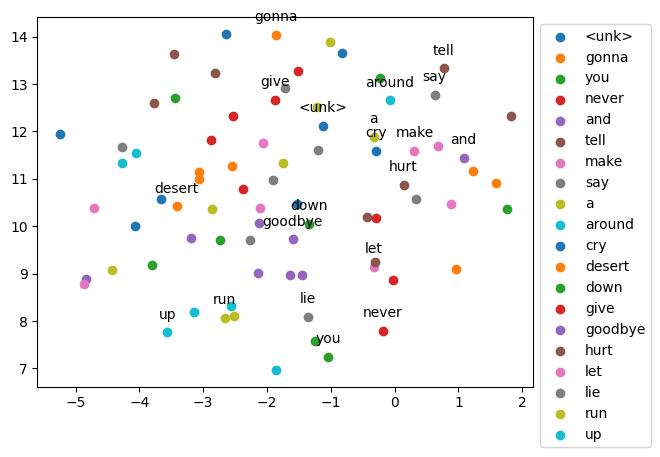

In [86]:
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Context 4

In [87]:
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4 )

save_path = '4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

  9%|███████▍                                                                          | 9/100 [00:00<00:02, 42.81it/s]

Generated Song:


 never feeling you get blind ask you the never were you been never never both never you never each guy around you the never you were never you do never never never blind just never you never never never you weve no gonna you you never ask blind never never never never both you you never never you never never you you never guy gonna say you never game never you never you never for never never commitments i say never guy never never you to never never dont never gonna never around the run gonna weve never you you


 20%|████████████████▏                                                                | 20/100 [00:00<00:01, 45.56it/s]

Generated Song:


 never never gonna you never you you never never gonna you gonna you never never gonna you gonna you you you you never never you you you you you never never never gonna you never never gonna you never you gonna never gonna you you never never gonna you you never never gonna you you never gonna you never gonna gonna you never never gonna you you never gonna tell you never gonna gonna you never never gonna you you never gonna you gonna gonna you you never never never gonna you you never gonna gonna never never gonna you


 30%|████████████████████████▎                                                        | 30/100 [00:00<00:01, 44.10it/s]

Generated Song:


 never never gonna say to you you down never gonna you gonna say a never gonna and gonna you you you you up never you you you you know never never never make a never im gonna gotta make you up never gonna you you up never gonna let you down never gonna make around and desert you never gonna make you up never gonna say goodbye never gonna tell a never and tell you never never gonna other you never gonna you gonna gonna you you tell too shy gonna you you never gonna gonna know never been going


 35%|████████████████████████████▎                                                    | 35/100 [00:00<00:01, 44.18it/s]

Generated Song:


 never and gonna say to you you know never gonna you gonna say a a lie and shy im im you you up never you other to you know never never never to a never im feeling gotta make you up never gonna you you up never gonna let you down never gonna run around and desert you never gonna make you up never gonna say goodbye never gonna tell a lie and hurt you never known each other for never gonna you gonna gonna aching you youre too shy to you you never gonna both know whats been going


 46%|█████████████████████████████████████▎                                           | 46/100 [00:01<00:01, 44.68it/s]

Generated Song:


 never known gonna say to love you know never hurt you gonna say a a lie and feeling im im you to up never this other im you know never never never to a how im feeling gotta make you up never gonna you you up never gonna let you down never gonna run around and desert you never gonna make you up never gonna say goodbye never gonna tell a lie and hurt you never known each other for so gonna you gonna been aching but youre too shy to im you never gonna both know whats been going


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:00, 44.98it/s]

Generated Song:


 never known no strangers to love you know never rules you gonna say a a full commitments what im im you to up never this other im other guy i never never to a how im feeling gotta make you cry never gonna you you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so gonna you gonna been aching but youre too shy to im you never we both know whats been going


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:01<00:00, 45.11it/s]

Generated Song:


 never known no strangers to love you know the rules other gonna say a a full commitments what im im you to up never this from im other guy i never never to a how im feeling gotta make you cry never gonna you you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so gonna you gonna been aching but youre too shy to im you never we both know whats been going


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:01<00:00, 47.93it/s]

Generated Song:


 never are no strangers to love you know the rules other gonna say a a full commitments what im thinking you to up never this from any other guy i never i to a how im feeling gotta make you cry never gonna you you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so gonna you gonna been aching but youre too shy to im you never we both know whats been going


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:01<00:00, 45.63it/s]

Generated Song:


 never are no strangers to love you know the rules other were say a a full commitments what im thinking you hurt i never this from any other guy i never i to a how im feeling gotta make you cry never gonna you you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so gonna you gonna been aching but youre too shy to im you never we both know whats been going


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.77it/s]

Generated Song:


 never are no strangers to love you know the rules other were say a a full commitments what im thinking you hurt i never this from any other guy i never i to a how im feeling gotta make you cry never gonna you you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so gonna you gonna been aching but youre too shy to see you never we both know whats been going


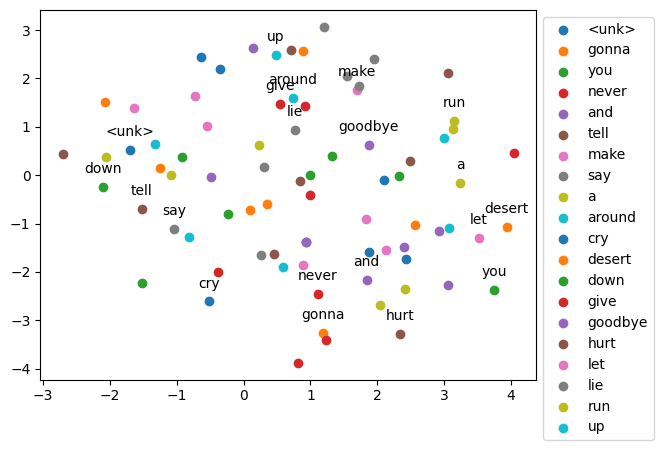

In [88]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Context 8

In [89]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

  5%|████                                                                              | 5/100 [00:00<00:02, 45.78it/s]

Generated Song:


 down you never any you you commitments make guy to you you thinking goodbye you from you you goodbye make you to from each any to make just goodbye understand gonna to say to goodbye make commitments to make to each gonna understand around you never gonna you understand you never goodbye you never you never to gonna around you any you to goodbye to understand you to goodbye know you gonna never know you down you to goodbye to goodbye so to do any you you goodbye make long to commitments long to to you around to any long


 17%|█████████████▊                                                                   | 17/100 [00:00<00:01, 51.94it/s]

Generated Song:


 never down gonna you for love you never the you you you never never gonna i you never never make you gonna make you gonna gonna make you gonna i gonna never gonna gonna never gonna gonna never make you never gonna gonna make you never gonna gonna let you down never gonna let around down gonna gonna never gonna make you never never gonna let you down gonna tell a never never gonna you never you never you for never you you gonna you you you never gonna shy to gonna make gonna make gonna gonna never never going


 28%|██████████████████████▋                                                          | 28/100 [00:00<00:01, 45.36it/s]

Generated Song:


 never down gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i you gonna gonna tell you guy i gonna never gonna gonna never never gonna never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you down gonna tell a lie never hurt you never down never other for so you i gonna i you a never too shy to gonna make gonna make rules tell the been going


 39%|███████████████████████████████▌                                                 | 39/100 [00:00<00:01, 49.16it/s]

Generated Song:


 never down gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i you gonna im tell you guy i gonna never gonna gonna never never i never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you and gonna tell a lie never hurt you never down never other for so you i gonna i you a im too shy to gonna thinking tell make been tell the been going
Generated Song:


 never down gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i so gonna im tell you guy i gonna never gonna gonna never never i never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you and gonna tell a lie never hurt you never down never other for so you i gonna to you a im too shy to gonna thinking tell give too tell the been going


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:01<00:00, 49.86it/s]

Generated Song:


 never down gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i so gonna im tell so guy i gonna never gonna gonna never never i never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you and gonna tell a lie never hurt you never down never other for so you i gonna to you a im too shy to gonna thinking tell give been tell the been going


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:01<00:00, 47.39it/s]

Generated Song:


 never down gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i so gonna im tell so guy i gonna never gonna gonna never never i never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you and gonna tell a lie never hurt you never down never other for so you i gonna to you a im too shy to gonna thinking tell give been tell the been going


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:01<00:00, 48.65it/s]

Generated Song:


 never down gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i so gonna im tell so guy i gonna never gonna gonna never never i never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you and gonna tell a lie never hurt you never down never other for so you i gonna to you a im too shy to gonna thinking tell give been tell the been going
Generated Song:


 never down gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i so gonna im tell so guy i gonna never gonna gonna never never i never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you and gonna tell a lie never hurt you never down never other for so you i gonna to you a im too shy to gonna thinking tell give been give the been going


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.06it/s]

Generated Song:


 never too gonna other for love you never the rules you you never play gonna i you shy im thinking you gonna i so you im tell so guy i gonna never gonna gonna never never i never make you never gonna gonna say you and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say you and gonna tell a lie never hurt you never down never other for so you i gonna to you a im too shy to gonna thinking tell give been give the been going


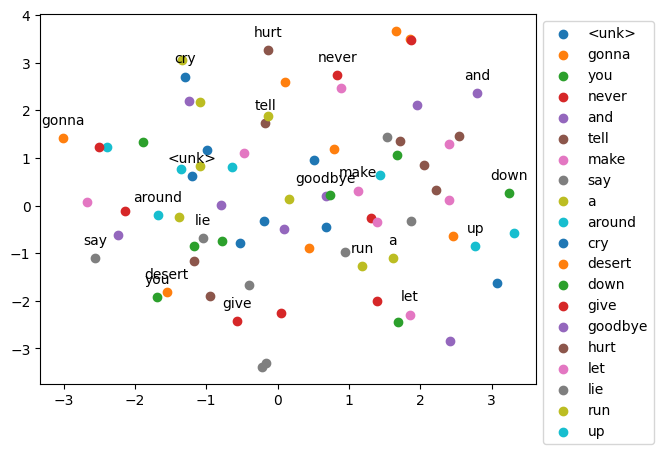

In [90]:
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Ao considerar a perda plotada para cada modelo, uma tendência discernível emerge: um aumento no tamanho do contexto se correlaciona com uma redução na perda. Embora essa abordagem específica não inclua a validação do modelo ou a utilização de métricas de avaliação de PNL convencionais, a evidência visual comprova seu desempenho superior.

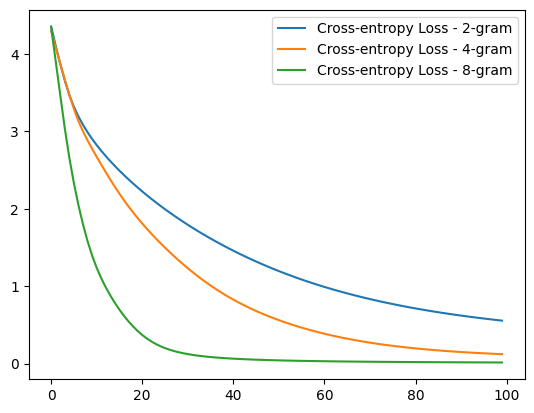

In [91]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

### Perplexidade
A perplexidade é uma métrica usada para avaliar a eficácia de modelos de linguagem ou modelos probabilísticos. Ela indica o quão bem um modelo prevê uma amostra de dados ou a probabilidade de um evento não visto. A perplexidade é comumente usada em tarefas de processamento de linguagem natural, como tradução automática, reconhecimento de fala e geração de linguagem.

A perplexidade é derivada do conceito de perda de entropia cruzada, que mede a dissimilaridade entre as probabilidades previstas e as reais.

$$\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \ln(p_i)$$

A perda de entropia cruzada é calculada ao se tomar a soma negativa dos produtos dos rótulos verdadeiros e do logaritmo das probabilidades previstas sobre as classes.

Tomando o exponencial da perda média de entropia cruzada, obtemos o valor de perplexidade.

$$\text{Perplexity} = e^{\frac{1}{N} \text{Cross-Entropy Loss}}$$

Um valor de perplexidade mais baixo indica que o modelo está mais confiante e preciso ao prever os dados. Por outro lado, uma perplexidade mais alta sugere que o modelo é menos certo e menos preciso em suas previsões.

A perplexidade pode ser vista como uma estimativa do número médio de opções que o modelo tem para a próxima palavra ou evento em uma sequência. Uma perplexidade mais baixa significa que o modelo está mais certo sobre a próxima palavra, enquanto uma perplexidade mais alta indica que há mais escolhas possíveis.

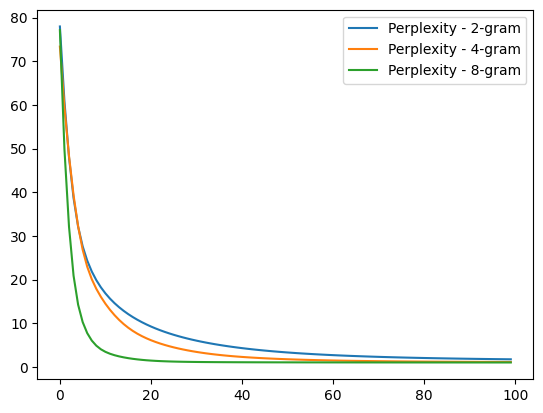

In [92]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()